# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas as pd  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF
from sklearn.metrics import mean_squared_error as mse 
from scipy.ndimage.interpolation import shift

In [5]:
import scipy.stats
help(scipy.stats)

Help on package scipy.stats in scipy:

NAME
    scipy.stats - .. _statsrefmanual:

DESCRIPTION
    Statistical functions (:mod:`scipy.stats`)
    
    .. currentmodule:: scipy.stats
    
    This module contains a large number of probability distributions,
    summary and frequency statistics, correlation functions and statistical
    tests, masked statistics, kernel density estimation, quasi-Monte Carlo
    functionality, and more.
    
    Statistics is a very large area, and there are topics that are out of scope
    for SciPy and are covered by other packages. Some of the most important ones
    are:
    
    - `statsmodels <https://www.statsmodels.org/stable/index.html>`__:
      regression, linear models, time series analysis, extensions to topics
      also covered by ``scipy.stats``.
    - `Pandas <https://pandas.pydata.org/>`__: tabular data, time series
      functionality, interfaces to other statistical languages.
    - `PyMC3 <https://docs.pymc.io/>`__: Bayesian statistica

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

There are 997 observations in the dataset


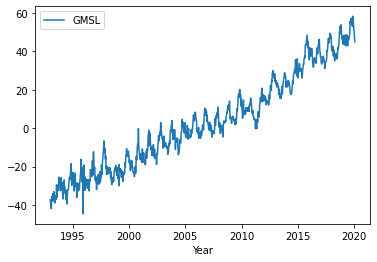

In [2]:
data = pd.read_csv("sealevel.csv")
data_cleaned = data.loc[:,["Year", "GMSL"]]
data_cleaned.plot(x = "Year", y = "GMSL")

print("There are", len(data_cleaned), "observations in the dataset")

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** <span style="color:blue">A regular parametric linear regression can be fitted to model the general response or linear trend. We want to get rid of this in order to use an autoregressive model that explains the temporal relations and properties between correlated samples ignored by simple linerar regression</span>

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

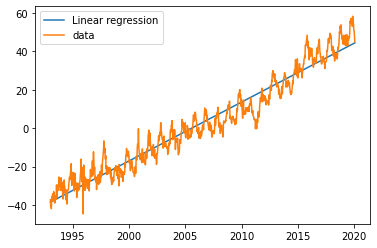

In [3]:
model = lm.LinearRegression().fit(X = data_cleaned[["Year"]], y = data_cleaned[["GMSL"]])
predictions = model.predict(data_cleaned[["Year"]])

plt.plot(data_cleaned[["Year"]], predictions, label = "Linear regression")
plt.plot(data_cleaned[["Year"]], data_cleaned[["GMSL"]], label = "data")
plt.legend()
plt.show()


In [4]:
data_no_mean = data_cleaned[["GMSL"]] - predictions
data_no_mean.rename(columns={"GMSL":"GMSL residuals"}, inplace = True)

<AxesSubplot:>

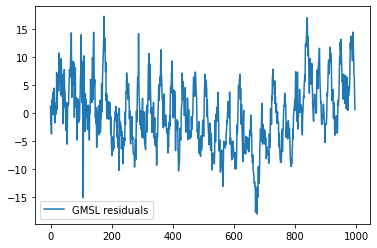

In [5]:
data_no_mean.plot()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

In [6]:
train = data_no_mean.iloc[0:700,:]
test = data_no_mean.iloc[701:len(data_no_mean),:]
print("train data samples: {0}, test data samples {1}".format(len(train), len(test)))

train data samples: 700, test data samples 296


## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [7]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = y.shape[0]
    
    # Construct the regression matrix
    Phi = np.zeros((n-p, p))# <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[(p-(j+1)): (n-(j+1)), 0] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [8]:
coef = fit_ar(train.to_numpy(), 10)

In [9]:
coef

array([[ 0.62156052,  0.10763277,  0.15104657,  0.1745703 , -0.02184709,
        -0.05955406, -0.09578106,  0.07585221, -0.11175939,  0.02305208]])

**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [10]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = theta.shape[1]
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m+1)
    for i in range(m):
        y_pred[i] =  (np.flip(y_target[i:i+p]) * theta).sum()
        
    return y_pred

In [11]:
predictions_all = predict_ar_1step(coef, data_no_mean.to_numpy().flatten())

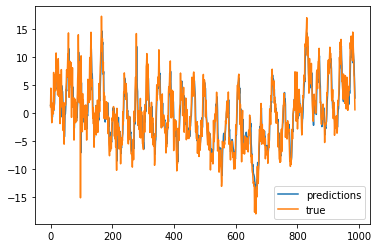

In [12]:
x = np.arange(0,predictions_all.shape[0]-1)

y_predicted = predictions_all[:predictions_all.shape[0]-1]

y_true = data_no_mean[10:].to_numpy().flatten()
plt.plot(x,y_predicted, label = "predictions")
plt.plot(x,y_true, label = "true")
plt.legend()
plt.show()

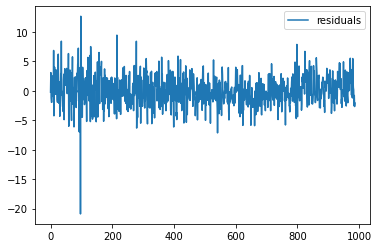

In [13]:
plt.plot(y_true - y_predicted, label = "residuals")
plt.legend()
plt.show()

In [14]:
mse(y_true, y_predicted)

6.679576251714483

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

In [15]:
predictions_test = predict_ar_1step(coef, test.to_numpy().flatten())

In [16]:
residuals_test = test[10:].to_numpy().flatten() - predictions_test[:-1]

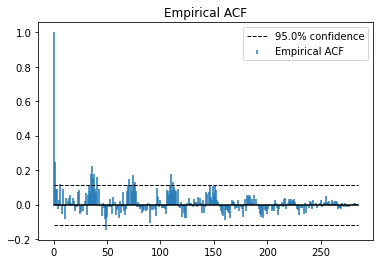

In [17]:
acfplot(residuals_test)

**A7:** <span style="color:blue">We can clearly observe that for residuals the ACF depends on the time lag and slowly fluctuates decreasing to 0 in the last samples. Residuals also fall inbetween the confidence interval lines. We can still se that there's some periodicity on the polarity switching and further decrease of the ACF values that could be solved by improving the order p of the model </span>

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [18]:

train_error = np.zeros(180)
test_error = np.zeros(180)

for i in range(180):
    p = i + 2
    coef = fit_ar(train.to_numpy(), p)
    predictions_train = predict_ar_1step(coef, train.to_numpy().flatten())
    train_error[i] = mse(train.to_numpy().flatten()[(p):], predictions_train[:-1])
    predictions_test = predict_ar_1step(coef, test.to_numpy().flatten())
    test_error[i] = mse(test.to_numpy().flatten()[(p):], predictions_test[:-1])



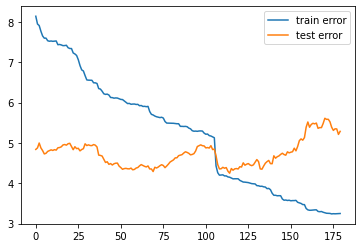

In [19]:
plt.plot(train_error, label = "train error")
plt.plot(test_error, label = "test error")
plt.legend()
plt.show()

In [20]:
np.argmin(test_error)+2

116

In [21]:
np.argmin(abs(test_error- train_error))+2

116

**A8:**
- Train error decreases almost monotonically when increasing the order *p*. On the other hand, the test error shows a behaviour with some several valleys and peaks over the p scope. Then after p=132 the test error starts to increase again showing we might be overfitting.
  
- p = 116 gives the lowest test error for the model to have more potential of generalization. It is shown, moreover, with the posterior increasing of p that the model starts performing with less accuracy when it comes to unseen data. Clear sign of overfitting.

- However, after having done some trials we have consider to use a p=50 model in order for the model not to be overly complex and not to overfit. It gives a similar test error as the aforemention error.  

    

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

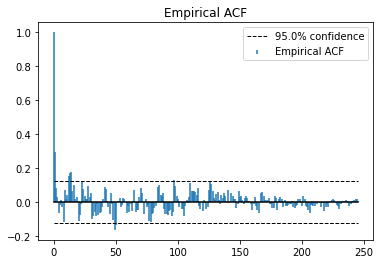

In [22]:
p = 50
coef = fit_ar(train.to_numpy(), p)
predictions_test = predict_ar_1step(coef, test.to_numpy().flatten())
test_residuals = test.to_numpy().flatten()[(p):] -  predictions_test[:-1]
acfplot(test_residuals)

**A9:** <span style="color:blue">
Here with an increased p we see that the ACF falls between the interval lines and diminishes to zero faster without a significant pattern (less noticeable than p=10) other than the switch of sign. Therefore we can conclude there's less dependence on the lag so residuals seem to be more distributed as white noise.
</span> 

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

In [23]:
coef

array([[ 4.83894885e-01,  7.01521648e-02,  1.35628365e-01,
         1.63220243e-01,  4.01432912e-02,  2.17910339e-02,
        -7.26976725e-02,  1.07835127e-01, -7.97824283e-02,
         6.23738214e-02, -5.39020615e-02, -4.28878873e-02,
         1.68835929e-02, -7.59840284e-02,  7.89109327e-02,
        -3.25671254e-02,  8.76744736e-02, -1.81207322e-02,
        -2.24290461e-02,  4.27747287e-02, -1.03264407e-02,
        -2.35659623e-02, -6.52829889e-02,  4.08319902e-02,
        -2.63926401e-02, -2.18448089e-02, -1.13587454e-02,
         2.49414742e-03,  4.57459461e-02, -3.13739752e-02,
         4.26396858e-02,  9.37385200e-02,  2.26961463e-02,
         2.05449632e-02,  3.43703051e-02,  9.85329280e-02,
         2.43273527e-02,  3.09729499e-02, -9.39410192e-02,
        -2.08607907e-02, -1.44513870e-05, -3.57561882e-02,
        -4.49527087e-02,  4.27023617e-02, -6.28470085e-02,
        -1.36826298e-02, -7.60974520e-02,  4.98742956e-02,
        -3.52535510e-03,  3.18438739e-02]])

**A10:**

In [24]:


def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point

    for i in range(m):
        prediction = (phi * theta).sum()
        y_sim[i] = prediction
        phi = shift(phi, 1, cval=prediction)
    
    return y_sim
    

In [25]:
sim_data = simulate_ar(train.to_numpy().flatten(), coef, 297)

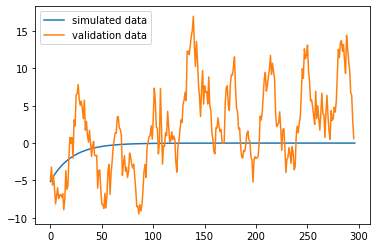

In [26]:
plt.plot(sim_data, label = "simulated data")
plt.plot(test.to_numpy(), label = "validation data")
plt.legend()
plt.show()

**Q11:** 
Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

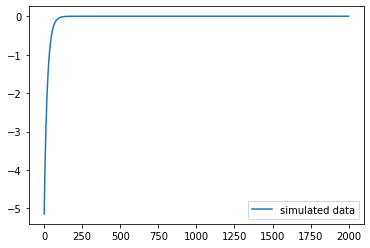

In [27]:
sim_data = simulate_ar(train.to_numpy().flatten(), coef, 2000)
plt.plot(sim_data, label = "simulated data")
plt.legend()
plt.show()

<span style="color:blue"> 
Error indeed converges to 0, we expected this to happen as the noise emulated in this process is defined as gaussian as well as it is a weak stationary process whose mean value expected for all predictions is constant and 0. 
<span> 

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [28]:
from sklearn.neural_network import MLPRegressor

def fit_nar(y, p, nhl):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = y.shape[0]
    
    # Construct the regression matrix
    Phi = np.zeros((n-p, p))# <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[(p-(j+1)): (n-(j+1)), 0] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:].ravel()  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr =  MLPRegressor(hidden_layer_sizes = nhl, max_iter = 1000).fit(Phi, yy)    

    return regr

In [29]:
def predict_nar_1step(model, y_target, p):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m+1)
    for i in range(m):
        data = np.flip(y_target[i:i+p]).reshape(1, -1)
        y_pred[i] =  model.predict(data)
        
    return y_pred

In [30]:
coef = fit_nar(train.to_numpy(), 50,(100))

In [31]:
predictions_all = predict_nar_1step(coef, data_no_mean.to_numpy().flatten(), 50)

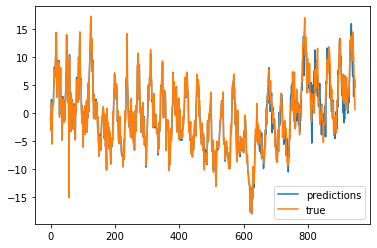

In [32]:
x = np.arange(0,predictions_all.shape[0]-1)

y_predicted = predictions_all[:predictions_all.shape[0]-1]

y_true = data_no_mean[50:].to_numpy().flatten()
plt.plot(x,y_predicted, label = "predictions")
plt.plot(x,y_true, label = "true")
plt.legend()
plt.show()

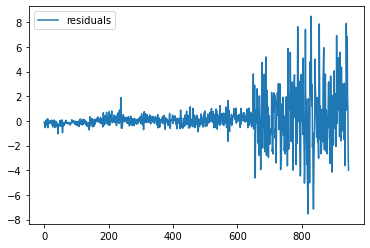

In [33]:
plt.plot(y_true - y_predicted, label = "residuals")
plt.legend()
plt.show()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

In [187]:
!pip install scikit-optimize
# this library was used for optimisation, 
# optimisations will be commented out 

In [218]:
"""from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

space  = [Integer(1, 50, name='nlayer1'),
          Integer(1, 50, name='nlayer2'),
          Integer(1, 50, name='nlayer3'),
          Integer(1, 50, name='nlayer4'),
          Integer(1, 50, name='nlayer5')]

@use_named_args(space)
def optimise_wrapper(nlayer1, nlayer2, nlayer3, nlayer4, nlayer5):
    layers = (nlayer1, nlayer2, nlayer3, nlayer4, nlayer5)
    coef = fit_nar(train.to_numpy(), 50, layers)
    predictions_all = predict_nar_1step(coef, test.to_numpy().flatten(), 50)
    y_predicted = predictions_all[:predictions_all.shape[0]-1]
    y_true = test[50:].to_numpy().flatten()
    return mse(y_predicted, y_true)"""

In [219]:
#res_gp = gp_minimize(optimise_wrapper, space, n_calls=100, random_state=0, verbose = True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.9736
Function value obtained: 18.1600
Current minimum: 18.1600
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.2946
Function value obtained: 20.7895
Current minimum: 18.1600
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.5033
Function value obtained: 12.0448
Current minimum: 12.0448
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.4195
Function value obtained: 15.8817
Current minimum: 12.0448
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.5738
Function value obtained: 11.3423
Current minimum: 11.3423
Iteration No: 6 started. 

C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 7.0762
Function value obtained: 19.8662
Current minimum: 11.3423
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.9847
Function value obtained: 16.3145
Current minimum: 11.3423
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 2.7881
Function value obtained: 11.2945
Current minimum: 11.2945
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 3.7382
Function value obtained: 16.0119
Current minimum: 11.2945
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.7797
Function value obtained: 13.2722
Current minimum: 11.2945
Iteration No: 23 st

C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 4.9068
Function value obtained: 13.3192
Current minimum: 5.9089
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 2.4123
Function value obtained: 9.4363
Current minimum: 5.9089
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 3.2019
Function value obtained: 16.3830
Current minimum: 5.9089
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.8619
Function value obtained: 16.2290
Current minimum: 5.9089
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 4.2988
Function value obtained: 17.1490
Current minimum: 5.9089
Iteration No: 38 started.

C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 7.0838
Function value obtained: 45.8972
Current minimum: 5.9089
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 4.5851
Function value obtained: 16.8190
Current minimum: 5.9089
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 4.5689
Function value obtained: 14.9934
Current minimum: 5.9089
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.9758
Function value obtained: 47.6887
Current minimum: 5.9089
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.9415
Function value obtained: 11.6453
Current minimum: 5.9089
Iteration No: 45 started

C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 8.6957
Function value obtained: 14.2799
Current minimum: 5.9089
Iteration No: 68 started. Searching for the next optimal point.
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 5.6874
Function value obtained: 13.0015
Current minimum: 5.9089
Iteration No: 69 started. Searching for the next optimal point.


C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 6.9906
Function value obtained: 46.2683
Current minimum: 5.9089
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 3.5046
Function value obtained: 16.6791
Current minimum: 5.9089
Iteration No: 71 started. Searching for the next optimal point.
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 4.9996
Function value obtained: 13.2477
Current minimum: 5.9089
Iteration No: 72 started. Searching for the next optimal point.
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 6.6584
Function value obtained: 8.3556
Current minimum: 5.9089
Iteration No: 73 started. Searching for the next optimal point.
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 5.4985
Function value obtained: 8.8273
Current minimum: 5.9089
Iteration No: 74 started. 

In [220]:
#res_gp.fun

5.908886026898294

In [221]:
#res_gp.x

[2, 23, 43, 50, 40]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

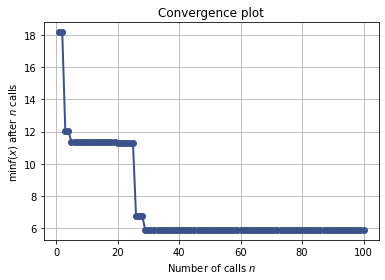

In [222]:
"""from skopt.plots import plot_convergence

plot_convergence(res_gp)"""

In [225]:
"""from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

space  = [Integer(1, 50, name='nlayer1'),
          Integer(1, 50, name='nlayer2'),
          Integer(1, 50, name='nlayer3'),]

@use_named_args(space)
def optimise_wrapper(nlayer1, nlayer2, nlayer3):
    layers = (nlayer1, nlayer2, nlayer3)
    coef = fit_nar(train.to_numpy(), 50, layers)
    predictions_all = predict_nar_1step(coef, test.to_numpy().flatten(), 50)
    y_predicted = predictions_all[:predictions_all.shape[0]-1]
    y_true = test[50:].to_numpy().flatten()
    return mse(y_predicted, y_true)"""

In [226]:
"""res_gp1 = gp_minimize(optimise_wrapper, space, n_calls=100, random_state=0, verbose = True)"""

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.0897
Function value obtained: 16.2627
Current minimum: 16.2627
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.7280
Function value obtained: 14.0374
Current minimum: 14.0374
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.3507
Function value obtained: 10.5044
Current minimum: 10.5044
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.7034
Function value obtained: 14.6774
Current minimum: 10.5044
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.3025
Function value obtained: 13.1805
Current minimum: 10.5044
Iteration No: 6 started. 

C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.6850
Function value obtained: 13.8187
Current minimum: 8.9352
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3544
Function value obtained: 48.0153
Current minimum: 8.9352
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 3.3793
Function value obtained: 10.1798
Current minimum: 8.9352
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 3.7455
Function value obtained: 11.1923
Current minimum: 8.9352
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.7466
Function value obtained: 10.3736
Current minimum: 8.9352
Iteration No: 19 started

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 3.1319
Function value obtained: 13.9474
Current minimum: 5.5488
Iteration No: 55 started. Searching for the next optimal point.
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 2.7817
Function value obtained: 13.0953
Current minimum: 5.5488
Iteration No: 56 started. Searching for the next optimal point.
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 2.0130
Function value obtained: 15.1416
Current minimum: 5.5488
Iteration No: 57 started. Searching for the next optimal point.
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 2.6227
Function value obtained: 14.9184
Current minimum: 5.5488
Iteration No: 58 started. Searching for the next optimal point.
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 2.0163
Function value obtained: 14.4729
Current minimum: 5.5488
Iteration No: 59 started

C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 3.7561
Function value obtained: 10.0709
Current minimum: 5.5488
Iteration No: 83 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 6.6485
Function value obtained: 11.4069
Current minimum: 5.5488
Iteration No: 84 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 10.4351
Function value obtained: 10.4401
Current minimum: 5.5488
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 8.1233
Function value obtained: 9.8685
Current minimum: 5.5488
Iteration No: 86 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 5.9750
Function value obtained: 16.2492
Current minimum: 5.5488
Iteration No: 87 started. Searching for the next optimal point.
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 4.6246
Function value obtained: 10.3742
Current minimum: 5.5488
Iteration No: 88 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 6.5106
Function value obtained: 10.4326
Current minimum: 5.5488
Iteration No: 89 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 5.6599
Function value obtained: 12.2436
Current minimum: 5.5488
Iteration No: 90 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 4.8201
Function value obtained: 10.4333
Current minimum: 5.5488
Iteration No: 91 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 4.0682
Function value obtained: 13.3127
Current minimum: 5.5488
Iteration No: 92 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 3.8237
Function value obtained: 9.1863
Current minimum: 5.5488
Iteration No: 93 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 4.0193
Function value obtained: 16.6132
Current minimum: 5.5488
Iteration No: 94 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 7.0711
Function value obtained: 10.2706
Current minimum: 5.5488
Iteration No: 95 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 4.7892
Function value obtained: 11.6729
Current minimum: 5.5488
Iteration No: 96 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 5.4863
Function value obtained: 9.3652
Current minimum: 5.5488
Iteration No: 97 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 4.7742
Function value obtained: 9.3259
Current minimum: 5.5488
Iteration No: 98 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 6.0698
Function value obtained: 15.9269
Current minimum: 5.5488
Iteration No: 99 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 4.2107
Function value obtained: 13.7746
Current minimum: 5.5488
Iteration No: 100 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 4.7015
Function value obtained: 16.4202
Current minimum: 5.5488


In [227]:
"""res_gp1.x"""

[2, 26, 23]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

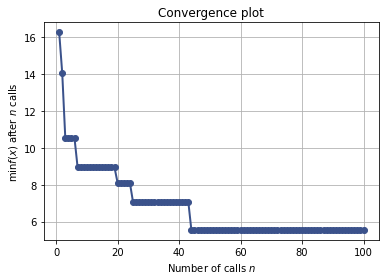

In [228]:
"""plot_convergence(res_gp1)"""

In [229]:
"""from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

space  = [Integer(1, 50, name='nlayer1'),
          Integer(1, 50, name='nlayer2'),
         Categorical()]

@use_named_args(space)
def optimise_wrapper(nlayer1, nlayer2):
    layers = (nlayer1, nlayer2)
    coef = fit_nar(train.to_numpy(), 50, layers)
    predictions_all = predict_nar_1step(coef, test.to_numpy().flatten(), 50)
    y_predicted = predictions_all[:predictions_all.shape[0]-1]
    y_true = test[50:].to_numpy().flatten()
    return mse(y_predicted, y_true)"""

In [230]:
"""res_gp1 = gp_minimize(optimise_wrapper, space, n_calls=100, random_state=0, verbose = True)"""

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.8609
Function value obtained: 13.9175
Current minimum: 13.9175
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.4329
Function value obtained: 14.1337
Current minimum: 13.9175
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.9518
Function value obtained: 17.8177
Current minimum: 13.9175
Iteration No: 4 started. Evaluating function at random point.


C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.9518
Function value obtained: 14.7048
Current minimum: 13.9175
Iteration No: 5 started. Evaluating function at random point.


C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.4834
Function value obtained: 16.5973
Current minimum: 13.9175
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.1912
Function value obtained: 11.6321
Current minimum: 11.6321
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.3487
Function value obtained: 16.9627
Current minimum: 11.6321
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.5791
Function value obtained: 16.4989
Current minimum: 11.6321
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 3.0175
Function value obtained: 16.1732
Current minimum: 11.6321
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. 

C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 3.3180
Function value obtained: 13.4091
Current minimum: 11.1092
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.8407
Function value obtained: 13.9673
Current minimum: 11.1092
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 5.0770
Function value obtained: 13.1244
Current minimum: 11.1092
Iteration No: 20 started. Searching for the next optimal point.


C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 2.2680
Function value obtained: 16.5239
Current minimum: 11.1092
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 6.3578
Function value obtained: 9.8671
Current minimum: 9.8671
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 5.2735
Function value obtained: 12.8419
Current minimum: 9.8671
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 5.5876
Function value obtained: 14.4681
Current minimum: 9.8671
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.3334
Function value obtained: 11.2252
Current minimum: 9.8671
Iteration No: 25 started

C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 6.2666
Function value obtained: 10.3031
Current minimum: 9.8671
Iteration No: 26 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 6.4661
Function value obtained: 11.4121
Current minimum: 9.8671
Iteration No: 27 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.3934
Function value obtained: 14.7403
Current minimum: 9.8671
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 5.8897
Function value obtained: 12.9075
Current minimum: 9.8671
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 4.8551
Function value obtained: 12.0695
Current minimum: 9.8671
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 4.2807
Function value obtained: 10.1851
Current minimum: 9.8671
Iteration No: 31 started. Searching for the next optimal point.


C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 6.5004
Function value obtained: 19.3961
Current minimum: 9.8671
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 5.6006
Function value obtained: 9.4876
Current minimum: 9.4876
Iteration No: 33 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 4.5596
Function value obtained: 9.5259
Current minimum: 9.4876
Iteration No: 34 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 5.0134
Function value obtained: 10.0108
Current minimum: 9.4876
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 3.3219
Function value obtained: 10.7418
Current minimum: 9.4876
Iteration No: 36 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 4.9168
Function value obtained: 8.0678
Current minimum: 8.0678
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 2.6076
Function value obtained: 15.9514
Current minimum: 8.0678
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 4.3422
Function value obtained: 10.6035
Current minimum: 8.0678
Iteration No: 39 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 4.9312
Function value obtained: 9.5328
Current minimum: 8.0678
Iteration No: 40 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 4.7663
Function value obtained: 13.6200
Current minimum: 8.0678
Iteration No: 41 started. Searching for the next optimal point.


C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.9995
Function value obtained: 23.0679
Current minimum: 8.0678
Iteration No: 42 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 4.1836
Function value obtained: 10.5215
Current minimum: 8.0678
Iteration No: 43 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 4.3099
Function value obtained: 10.5217
Current minimum: 8.0678
Iteration No: 44 started. Searching for the next optimal point.


C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 4.9614
Function value obtained: 14.4536
Current minimum: 8.0678
Iteration No: 45 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 4.8011
Function value obtained: 10.2121
Current minimum: 8.0678
Iteration No: 46 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 4.3514
Function value obtained: 12.2442
Current minimum: 8.0678
Iteration No: 47 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 4.4096
Function value obtained: 13.7380
Current minimum: 8.0678
Iteration No: 48 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 4.6031
Function value obtained: 10.2340
Current minimum: 8.0678
Iteration No: 49 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 4.1064
Function value obtained: 12.1928
Current minimum: 8.0678
Iteration No: 50 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 3.9892
Function value obtained: 12.7224
Current minimum: 8.0678
Iteration No: 51 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 5.0196
Function value obtained: 10.8726
Current minimum: 8.0678
Iteration No: 52 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 2.3923
Function value obtained: 9.3539
Current minimum: 8.0678
Iteration No: 53 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 3.9358
Function value obtained: 8.4356
Current minimum: 8.0678
Iteration No: 54 started. Searching for the next optimal point.
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 4.6118
Function value obtained: 13.8058
Current minimum: 8.0678
Iteration No: 55 started. Searching for the next optimal point.
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 4.0160
Function value obtained: 14.2437
Current minimum: 8.0678
Iteration No: 56 started. Searching for the next optimal point.
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 3.2378
Function value obtained: 13.0584
Current minimum: 8.0678
Iteration No: 57 started. Searching for the next optimal point.
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 2.2581
Function value obtained: 8.6689
Current minimum: 8.0678
Iteration No: 58 started. 

C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 2.8383
Function value obtained: 8.8982
Current minimum: 8.0678
Iteration No: 64 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 2.9168
Function value obtained: 15.5081
Current minimum: 8.0678
Iteration No: 65 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 3.7723
Function value obtained: 9.0854
Current minimum: 8.0678
Iteration No: 66 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 3.2956
Function value obtained: 8.9120
Current minimum: 8.0678
Iteration No: 67 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 2.8607
Function value obtained: 15.9668
Current minimum: 8.0678
Iteration No: 68 started. Searching for the next optimal point.
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 2.2248
Function value obtained: 15.5533
Current minimum: 8.0678
Iteration No: 69 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 2.9847
Function value obtained: 10.1562
Current minimum: 8.0678
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 3.4679
Function value obtained: 10.5211
Current minimum: 8.0678
Iteration No: 71 started. Searching for the next optimal point.
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 3.1800
Function value obtained: 8.3077
Current minimum: 8.0678
Iteration No: 72 started. Searching for the next optimal point.
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 2.8718
Function value obtained: 15.5438
Current minimum: 8.0678
Iteration No: 73 started. Searching for the next optimal point.
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 4.4632
Function value obtained: 11.2905
Current minimum: 8.0678
Iteration No: 74 started.

C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 2.3996
Function value obtained: 9.2891
Current minimum: 8.0678
Iteration No: 75 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 3.0820
Function value obtained: 11.2476
Current minimum: 8.0678
Iteration No: 76 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 2.4512
Function value obtained: 16.1475
Current minimum: 8.0678
Iteration No: 77 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 4.1569
Function value obtained: 11.5918
Current minimum: 8.0678
Iteration No: 78 started. Searching for the next optimal point.
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 4.9442
Function value obtained: 12.4769
Current minimum: 8.0678
Iteration No: 79 started. Searching for the next optimal point.
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 6.3842
Function value obtained: 11.3243
Current minimum: 8.0678
Iteration No: 80 started. Searching for the next optimal point.
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 5.0708
Function value obtained: 13.6496
Current minimum: 8.0678
Iteration No: 81 started. Searching for the next optimal point.
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 3.3603
Function value obtained: 16.0143
Current minimum: 8.0678
Iteration No: 82 started

C:\Users\marty\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 6.9818
Function value obtained: 14.3967
Current minimum: 8.0678
Iteration No: 84 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 2.8002
Function value obtained: 10.9358
Current minimum: 8.0678
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3.2093
Function value obtained: 14.8284
Current minimum: 8.0678
Iteration No: 86 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 4.7773
Function value obtained: 9.8111
Current minimum: 8.0678
Iteration No: 87 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 4.4029
Function value obtained: 11.3619
Current minimum: 8.0678
Iteration No: 88 started. Searching for the next optimal point.
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 4.0162
Function value obtained: 11.7444
Current minimum: 8.0678
Iteration No: 89 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 3.4138
Function value obtained: 16.1075
Current minimum: 8.0678
Iteration No: 90 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 4.7634
Function value obtained: 15.4350
Current minimum: 8.0678
Iteration No: 91 started. Searching for the next optimal point.
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 2.9809
Function value obtained: 13.4408
Current minimum: 8.0678
Iteration No: 92 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 4.7029
Function value obtained: 9.8645
Current minimum: 8.0678
Iteration No: 93 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 5.2948
Function value obtained: 12.0324
Current minimum: 8.0678
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 5.0473
Function value obtained: 12.6209
Current minimum: 8.0678
Iteration No: 95 started. Searching for the next optimal point.
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 4.9049
Function value obtained: 11.6189
Current minimum: 8.0678
Iteration No: 96 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 4.8829
Function value obtained: 11.5132
Current minimum: 8.0678
Iteration No: 97 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 4.7230
Function value obtained: 11.9203
Current minimum: 8.0678
Iteration No: 98 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 5.3464
Function value obtained: 10.3029
Current minimum: 8.0678
Iteration No: 99 started. Searching for the next optimal point.


C:\Users\marty\anaconda3\envs\time series\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 5.2967
Function value obtained: 14.7024
Current minimum: 8.0678
Iteration No: 100 started. Searching for the next optimal point.
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 4.6517
Function value obtained: 11.7899
Current minimum: 8.0678


In [231]:
"""res_gp1.x"""

[47, 50]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

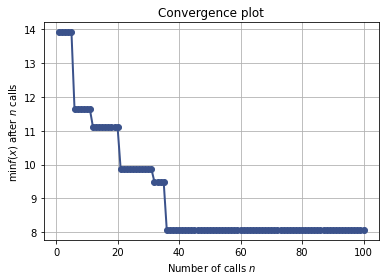

In [232]:
"""plot_convergence(res_gp1)"""

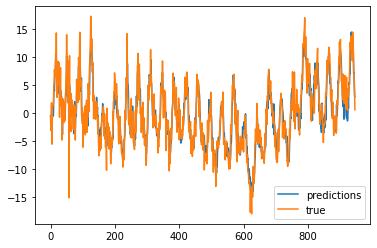

In [34]:
## tuned params: 3 layers 2, 26, 23

coef = fit_nar(train.to_numpy(), 50,(2,26,23))
predictions_all = predict_nar_1step(coef, data_no_mean.to_numpy().flatten(), 50)

x = np.arange(0,predictions_all.shape[0]-1)

y_predicted = predictions_all[:predictions_all.shape[0]-1]

y_true = data_no_mean[50:].to_numpy().flatten()
plt.plot(x,y_predicted, label = "predictions")
plt.plot(x,y_true, label = "true")
plt.legend()
plt.show()

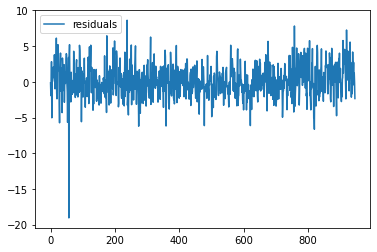

In [35]:
plt.plot(y_true - y_predicted, label = "residuals")
plt.legend()
plt.show()

In [36]:
mse(y_true, y_predicted)

5.215946037464721

MSE of AR and optimised NAR are very similar, however NAR is much more complicated, slower model, thus for this specific task AR would be more preferred 